# Face Recognition 

## Importing Libraries

In [164]:
import matplotlib.pyplot as plt
import glob
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import os
import imghdr

## Load Folder

In [165]:
def load_images(data_path):
    images = []
    labels = []

    for person_name in os.listdir(data_path):
        person_dir = os.path.join(data_path, person_name)
        if os.path.isdir(person_dir):
            for image_filename in os.listdir(person_dir):
                if image_filename.endswith('.jpg'):
                    image_path = os.path.join(person_dir, image_filename)
                    image = cv2.imread(image_path)

                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    images.append(image)

                    labels.append(person_name)

    images = np.array(images)
    labels = np.array(labels)
    unique_labels = np.unique(labels)
    
    return {
        'data': images,
        'target': labels,
        'target_names': unique_labels
    }

dataset = load_images('./Data/')

In [166]:
print("Shape of images:", dataset['data'].shape)
print("Shape of labels:", dataset['target'].shape)
print("Unique labels:", dataset['target_names'].shape)

Shape of images: (13233, 250, 250, 3)
Shape of labels: (13233,)
Unique labels: (5749,)


## Data Visualization

### Image Distribuition of Top 20 People

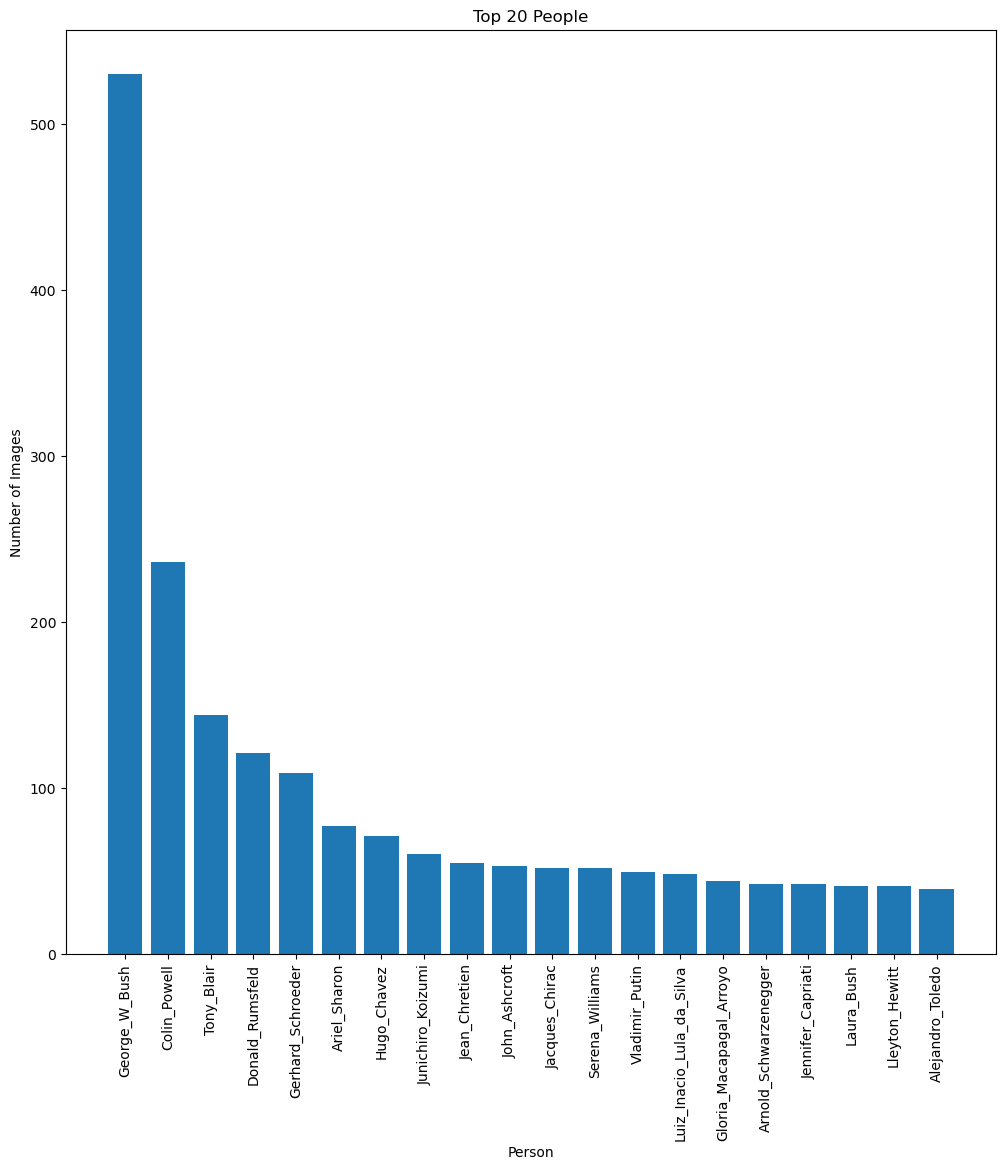

In [167]:
from collections import Counter

target_counts = Counter(dataset['target'])

top_20_people = target_counts.most_common(20)

plt.figure(figsize=(12, 12))
plt.bar(*zip(*top_20_people))
plt.xlabel('Person')
plt.xticks(rotation=90)
plt.ylabel('Number of Images')
plt.title('Top 20 People')
plt.show()

### Histogram

In [168]:
ranges = [(1, 1), (2, 5), (6, 10), (11, 20), (21, 30), (31, 80), (81, np.inf)]
labels = ['1', '2-5', '6-10', '11-20', '21-30', '31-80', '>81']

people_counts = [0] * len(ranges)
image_counts = [0] * len(ranges)

# For each person, increment the count for the appropriate range
for person, count in target_counts.items():
    for i, (min_count, max_count) in enumerate(ranges):
        if min_count <= count <= max_count:
            people_counts[i] += 1
            image_counts[i] += count
            break

# Calculate the percentages
total_people = sum(people_counts)
total_images = sum(image_counts)
people_percentages = [f"{count / total_people * 100:.2f}" for count in people_counts]
images_percentages = [f"{count / total_images * 100:.2f}" for count in image_counts]

# Create a DataFrame
df = pd.DataFrame({
    '# of images /person': labels,
    '# of people': people_counts,
    '% of people': people_percentages,
    '# of images': image_counts,
    '% of images': images_percentages
})

df

,# of images /person,# of people,% of people,# of images,% of images
0,1,4069,70.78,4069,30.75
1,2-5,1369,23.81,3739,28.26
2,6-10,168,2.92,1251,9.45
3,11-20,86,1.50,1251,9.45
4,21-30,25,0.43,613,4.63
5,31-80,27,0.47,1170,8.84
6,>81,5,0.09,1140,8.61


### Plot Some Images

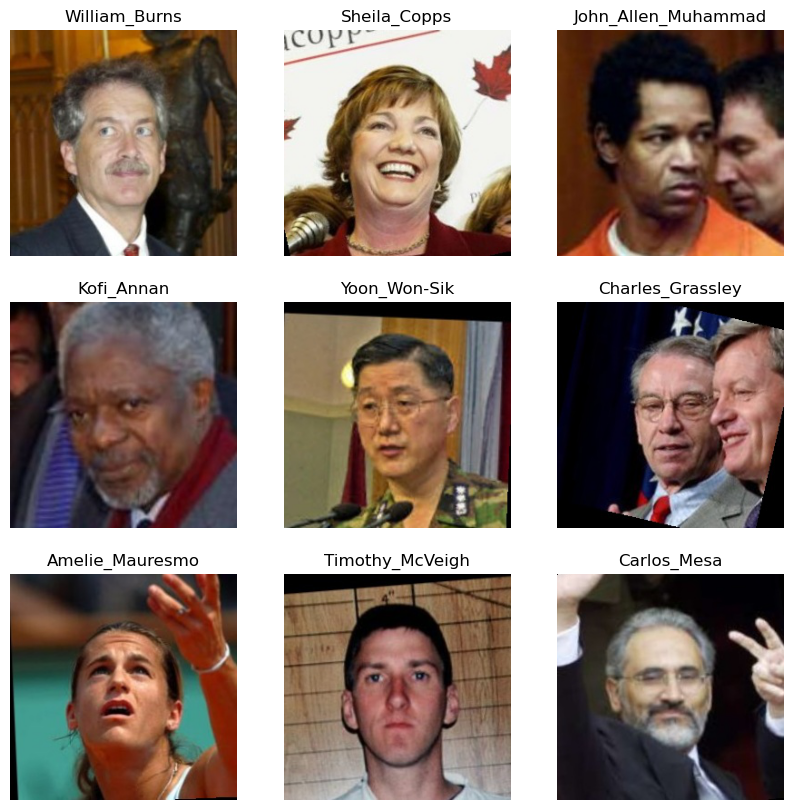

In [169]:
# Function to display a random set of images

def display_random_images(images, labels, rows, cols, cmap=None):
    fig = plt.figure(figsize=(10, 10))

    for i in range(1, cols * rows + 1):
        index = np.random.randint(len(images))
        plt.subplot(rows, cols, i)
        plt.axis('off')
        plt.imshow(images[index], cmap=cmap)
        plt.title(labels[index])

    plt.show()

display_random_images(dataset['data'], dataset['target'], 3, 3)

## Data Preprocessing

### Image Resizing

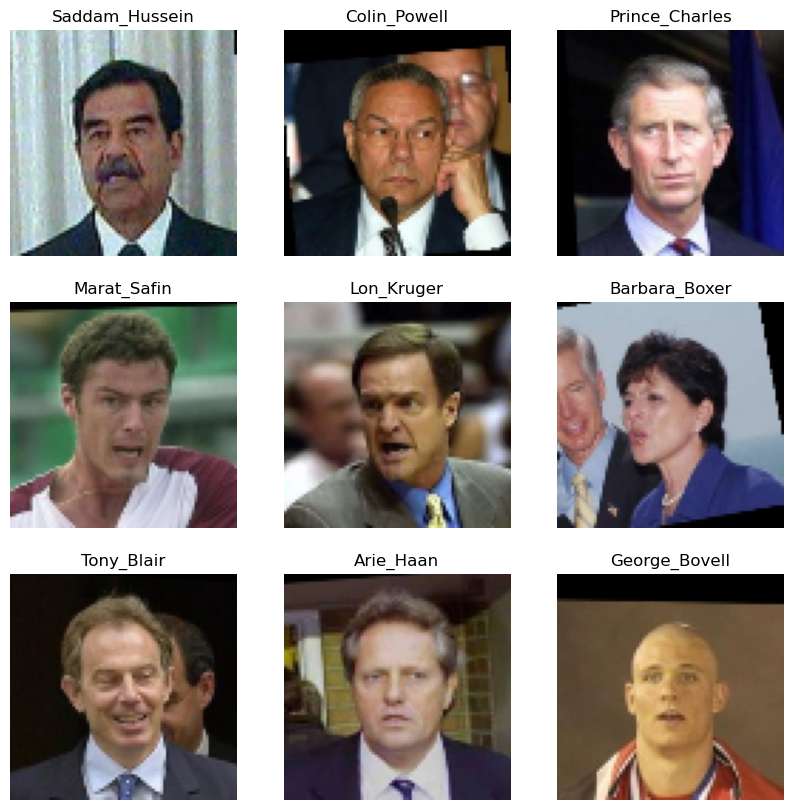

In [170]:
def resize_image(images, target_size=(100, 100)):
    resized_images = [cv2.resize(image, target_size) for image in images]
    return np.array(resized_images)

resized_images = resize_image(dataset['data'], target_size=(80, 80))


display_random_images(resized_images, dataset['target'], 3, 3)

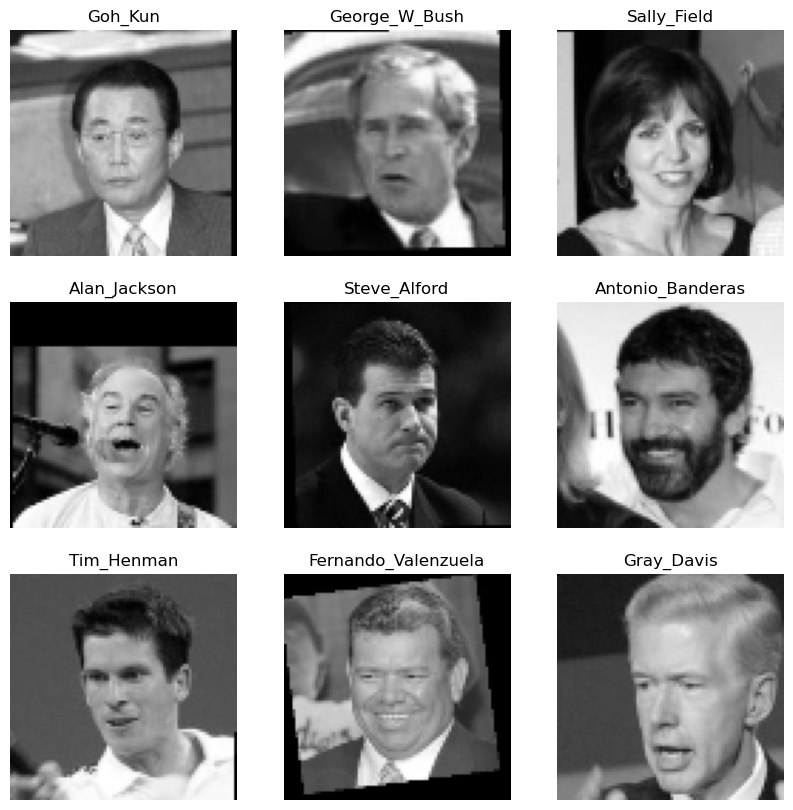

In [171]:
# Gray scale

def gray_scale(images):
    gray_images = [cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in images]
    return np.array(gray_images)

gray_images = gray_scale(resized_images)

display_random_images(gray_images, dataset['target'], 3, 3, cmap='gray')

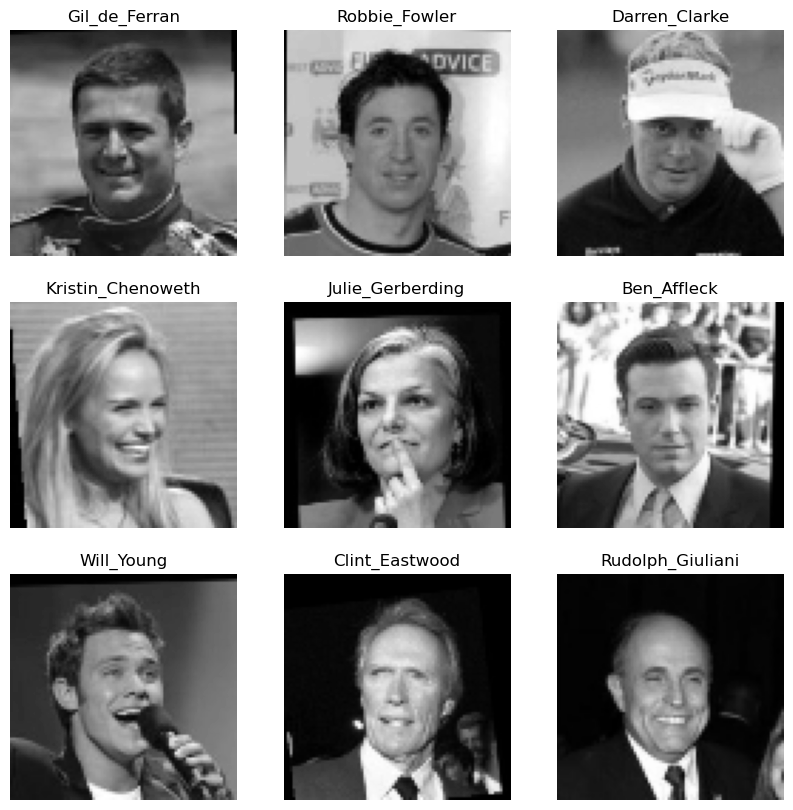

In [172]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_images = scaler.fit_transform(gray_images.reshape(-1, 80 * 80)).reshape(-1, 80, 80)


display_random_images(scaled_images, dataset['target'], 3, 3, cmap='gray')

### Feature Extractions

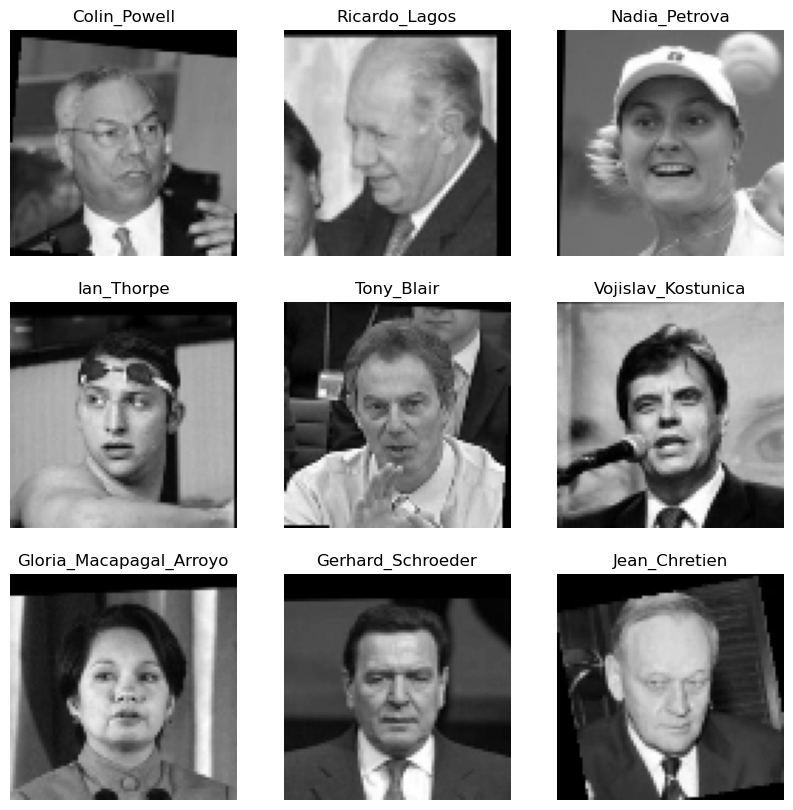

In [173]:
def filter_dataset(dataset, min_faces_per_person):
    # Count the number of images for each person
    target_counts = Counter(dataset['target'])

    # Initialize the filtered dataset
    filtered_dataset = {
        'data': [],
        'target': [],
        'target_names': set()
    }

    # For each image and its corresponding label
    for image, label in zip(dataset['data'], dataset['target']):
        # If this person has at least min_faces_per_person images
        if target_counts[label] >= min_faces_per_person:
            # Add this image and label to the filtered dataset
            filtered_dataset['data'].append(image)
            filtered_dataset['target'].append(label)
            filtered_dataset['target_names'].add(label)

    filtered_dataset['data'] = np.array(filtered_dataset['data'])
    filtered_dataset['target'] = np.array(filtered_dataset['target'])
    filtered_dataset['target_names'] = np.array(list(filtered_dataset['target_names']))

    return filtered_dataset

dataset['data'] = scaled_images

filtered_dataset = filter_dataset(dataset, min_faces_per_person=5)

display_random_images(filtered_dataset['data'], filtered_dataset['target'], 3, 3, cmap='gray')

In [174]:
filtered_dataset['data'].shape
filtered_dataset['target'].shape


print("Shape of images:", filtered_dataset['data'].shape)

Shape of images: (5985, 80, 80)


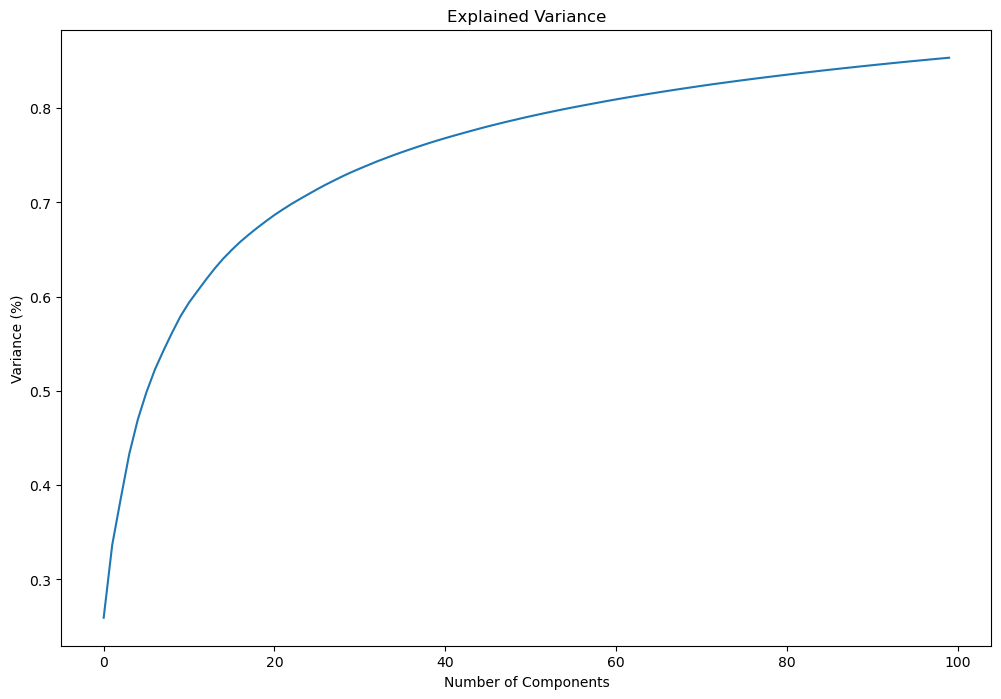

In [175]:
from sklearn.decomposition import PCA

X = filtered_dataset['data']
y = filtered_dataset['target']

X = X.reshape(-1, 80 * 80)

pca = PCA(n_components=100, whiten=True, random_state=42)

X_pca = pca.fit_transform(X)

# plot the explained variance ratio
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')
plt.show()

### Model Training

In [177]:
# SVM
from sklearn import svm
from sklearn.model_selection import cross_val_score

# Create an SVM classifier
clf = svm.SVC(kernel="rbf", class_weight="balanced")

# Perform 10-fold cross-validation
scores = cross_val_score(clf, X_pca, y, cv=10)


# print cross-validation scores with %
print("Cross-validation scores: {}".format(scores * 100))
print("Average cross-validation score: {:.2f}%".format(scores.mean() * 100))

# Train the model
clf.fit(X_pca, y)

c:\Users\yokiclearwater\miniconda3\envs\data_science\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


Cross-validation scores: [ 8.01335559  9.34891486  9.18196995  7.84641068  8.34724541 10.70234114
 12.54180602 10.70234114  8.52842809  9.19732441]
Average cross-validation score: 9.44%


SVC(class_weight='balanced')

### Save & Load Model

In [ ]:
import pickle

# if model.pkl not exists, create it
if not os.path.exists('model.pkl'):
    with open('model.pkl', 'wb') as f:
        pickle.dump(clf, f)

Predicted label: Mahmoud_Abbas
Actual label: Mahmoud_Abbas


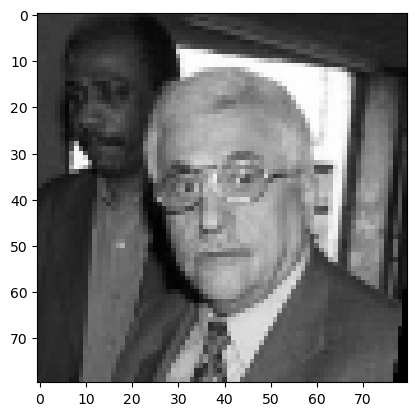

In [178]:
model_filename = './model.pkl'

pickle.dump(clf, open(model_filename, 'wb'))

# load the model from disk

loaded_model = pickle.load(open(model_filename, 'rb'))

# Test the model on a random image

index = np.random.randint(len(filtered_dataset['data']))

test_image = filtered_dataset['data'][index]

plt.imshow(test_image, cmap='gray')

test_image = test_image.reshape(1, -1)

test_image_pca = pca.transform(test_image)

pred = loaded_model.predict(test_image_pca)

print("Predicted label:", pred[0])
print("Actual label:", filtered_dataset['target'][index])

#### Test WITH REAL IMAGE

In [194]:
test_image = cv2.imread('./Data/Gloria_Macapagal_Arroyo/Gloria_Macapagal_Arroyo_0013.jpg')

test_image = resize_image([test_image], target_size=(80, 80))[0]

test_image = gray_scale([test_image])[0]

# Scale the image
test_image = scaler.transform(test_image.reshape(1, -1))

# Reduce the dimensions
test_image = pca.transform(test_image)

# Make a prediction

pred = clf.predict(test_image)[0]

print("Prediction:", pred)

Prediction: Gloria_Macapagal_Arroyo
